# Correct for flawed plate design

We collected many plates in batches 9 and 10, but unfortunately, we applied only one perturbation per plate. This prevents us from using our standard per-plate normalization strategy.

We perform a different normalization strategy here.

In [1]:
import pathlib
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn import decomposition
from statsmodels.formula.api import ols

import plotnine as gg

from pycytominer import normalize
from pycytominer.cyto_utils import infer_cp_features

In [2]:
def test_batch_effect_contribution(df, n_components, pca_columns, model_formula):
    features = infer_cp_features(df)
    meta_features = infer_cp_features(df, metadata=True)

    feature_df = df.loc[:, features]

    pca = decomposition.PCA(n_components=n_components).fit(feature_df)
    pca_batch_df = pca.transform(feature_df)

    pca_batch_df = pd.concat(
        [
            df.loc[:, meta_features],
            pd.DataFrame(pca_batch_df, columns=pca_columns),
        ], axis="columns"
    )
    
    melt_df = pd.melt(
        pca_batch_df,
        id_vars=meta_features,
        value_vars=pca_columns,
        var_name="pca_component",
        value_name="pca_value"
    )
    
    anova_results = []
    for pca_component in pca_columns:
        subset_melt_df = melt_df.query("pca_component == @pca_component")

        # Setup model
        model = ols(model_formula, data=subset_melt_df).fit()

        # Generate ANOVA table
        anova_table = (
            sm.stats.anova_lm(model, typ=2)
            .reset_index()
            .rename({"index": "factor"}, axis="columns")
            .assign(pca=pca_component)
        )
        anova_results.append(anova_table)

    anova_results = pd.concat(anova_results).reset_index(drop=True).dropna()
    anova_results = anova_results.assign(neg_log_p=-np.log10(anova_results.loc[:, "PR(>F)"]), batch=batch)

    anova_results.pca = pd.Categorical(anova_results.pca, categories=pca_columns)
    anova_results = anova_results.assign(component_number=[int(x.split("_")[1]) for x in anova_results.pca])
    return anova_results

In [3]:
# Load profiles
profile_dir = pathlib.Path("profiles/")
standard_file_suffix = "_normalized.csv.gz"

profile_data = {
    "2019_11_22_Batch7": {
        "plates": [],
        "file_suffix": standard_file_suffix
    },
    "2020_07_02_Batch8": {
        "plates": [],
        "file_suffix": standard_file_suffix
    },
    "2020_08_24_Batch9": {
        "plates": [],
        "file_suffix": standard_file_suffix
    },
    "2020_09_08_Batch10": {
        "plates": [],
        "file_suffix": standard_file_suffix
    },
}

for batch in profile_data:
    batch_dir = pathlib.Path(f"{profile_dir}/{batch}")
    
    for plate_file in batch_dir.iterdir():
        plate_name = plate_file.name
        
        if ".DS_Store" in plate_name:
            continue
        
        file_suffix = profile_data[batch]["file_suffix"]
        plate_file = pathlib.Path(f"{plate_file}/{plate_name}{file_suffix}")
        plate_df = pd.read_csv(plate_file)

        plate_df = (
            plate_df
            .assign(
                Metadata_batch=batch,
                Metadata_profile_number=[
                    f"profile_{plate_name}_{batch}_{x}" for x in range(0, plate_df.shape[0])
                ]
            )
        )
        profile_data[batch]["plates"].append(plate_df)
        
# Combine profiles
for batch in profile_data:
    profile_data[batch]["plates"] = pd.concat(profile_data[batch]["plates"]).reset_index(drop=True)

In [4]:
# Detect the impact of batch - is it necessary to adjust?
n_components = 20
pca_columns = [f"pca_{x}" for x in range(0, n_components)]
model_formula = "pca_value ~ Metadata_clone_number + Metadata_treatment + Metadata_Plate + Metadata_treatment * Metadata_Plate"

anova_results_full = []
for batch in profile_data:
    df = profile_data[batch]["plates"]
    anova_results = test_batch_effect_contribution(
        df, n_components, pca_columns, model_formula
    )
    anova_results_full.append(anova_results)
    
anova_results_full_df = pd.concat(anova_results_full).reset_index(drop=True)

print(anova_results_full_df.shape)
anova_results_full_df.head()

(320, 9)


,factor,sum_sq,df,F,PR(>F),pca,neg_log_p,batch,component_number
0,Metadata_clone_number,1.221161e+05,8.0,4.895417e+01,1.710854e-32,pca_0,31.766787,2019_11_22_Batch7,0
1,Metadata_treatment,2.141004e+04,1.0,6.866321e+01,3.486747e-13,pca_0,12.457580,2019_11_22_Batch7,0
2,Metadata_Plate,6.577741e-17,1.0,2.109519e-19,1.000000e+00,pca_0,-0.000000,2019_11_22_Batch7,0
3,Metadata_treatment:Metadata_Plate,3.628067e+03,1.0,1.163542e+01,9.112627e-04,pca_0,3.040356,2019_11_22_Batch7,0
4,Metadata_clone_number,2.572965e+04,8.0,1.088909e+01,3.756545e-11,pca_1,10.425211,2019_11_22_Batch7,1


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures_batch_effect/normalized_pca_anova_batch_effects.png
  warn('Filename: {}'.format(filename))


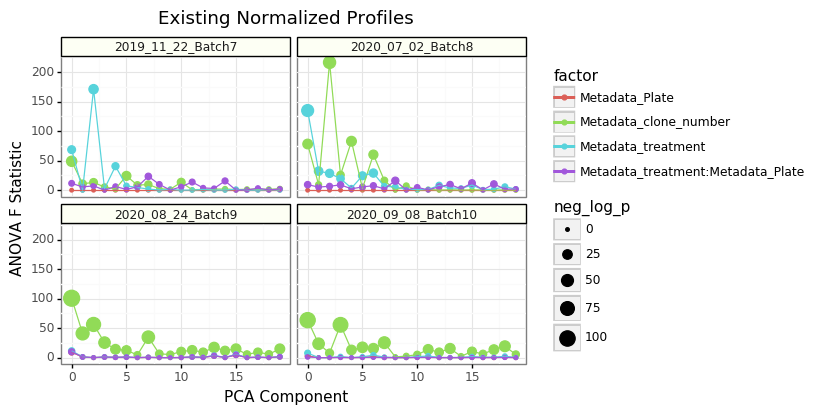

<ggplot: (314710059)>

In [5]:
normalized_gg = (
    gg.ggplot(anova_results_full_df, gg.aes(x="component_number", y="F", color="factor")) +
    gg.geom_point(gg.aes(size="neg_log_p")) +
    gg.geom_line() +
    gg.theme_bw() +
    gg.xlab("PCA Component") +
    gg.ylab("ANOVA F Statistic") +
    gg.facet_wrap("~batch") +
    gg.theme(strip_background=gg.element_rect(colour="black", fill="#fdfff4")) +
    gg.ggtitle("Existing Normalized Profiles")
)

output_file = pathlib.Path("figures_batch_effect/normalized_pca_anova_batch_effects.png")
normalized_gg.save(output_file, height=4, width=6)

normalized_gg

## Try combining "matched" plates before normalization

In [6]:
file_suffix = "_augmented.csv.gz"

matched_plates = {
    "2020_08_24_Batch9": {
        "CB5083": {
            "plates": ["218775", "218774", "218697", "218696"],
            "data": []
        },
        "ixazomib": {
            "plates": ["218699", "218698"],
            "data":[]
        },
    },
    "2020_09_08_Batch10": {
        "CB5083": {
            "plates": ["218852", "218853", "218856", "218857"],
            "data": []
        },
        "ixazomib": {
            "plates": ["218854", "218855", "218858", "218859"],
            "data": []
        }
    }
}

for batch in matched_plates:
    compound_matches = matched_plates[batch]
    for compound in compound_matches:
        batch_dir = pathlib.Path(f"{profile_dir}/{batch}")
    
        for plate_name in compound_matches[compound]["plates"]:
            if ".DS_Store" in plate_name:
                continue

            plate_file = pathlib.Path(f"{batch_dir}/{plate_name}/{plate_name}{file_suffix}")
            matched_plates[batch][compound]["data"].append(pd.read_csv(plate_file).assign(Metadata_batch=batch))

# Combine profiles
for batch in matched_plates:
    compound_matches = matched_plates[batch]
    for compound in compound_matches:
        matched_plates[batch][compound]["data"] = (
            pd.concat(matched_plates[batch][compound]["data"])
            .reset_index(drop=True)
        )

In [7]:
# Normalize profiles
for batch in matched_plates:
    compound_matches = matched_plates[batch]
    for compound in compound_matches:
        df = matched_plates[batch][compound]["data"]
        normalized_data = normalize(
            profiles=df,
            features="infer",
            meta_features="infer",
            samples="all",
            method="standardize"
        )
        
        matched_plates[batch][compound]["normalized_data"] = normalized_data

In [8]:
# Detect the impact of batch - is it necessary to adjust?
n_components = 20
pca_columns = [f"pca_{x}" for x in range(0, n_components)]
model_formula = "pca_value ~ Metadata_clone_number + Metadata_treatment + Metadata_Plate + Metadata_treatment * Metadata_Plate"

anova_results_full_new_normalized = []
for batch in matched_plates:
    compound_matches = matched_plates[batch]
    for compound in compound_matches:
        df = matched_plates[batch][compound]["normalized_data"]
        
        anova_results = test_batch_effect_contribution(
            df, n_components, pca_columns, model_formula
        )
        
        anova_results_full_new_normalized.append(anova_results.assign(compound=compound))
    
anova_results_full_new_normalized_df = pd.concat(anova_results_full_new_normalized).reset_index(drop=True)

print(anova_results_full_new_normalized_df.shape)
anova_results_full_new_normalized_df.head()

(320, 10)


,factor,sum_sq,df,F,PR(>F),pca,neg_log_p,batch,component_number,compound
0,Metadata_clone_number,130901.298179,9.0,96.458755,1.724465e-72,pca_0,71.763346,2020_08_24_Batch9,0,CB5083
1,Metadata_treatment,6832.170696,1.0,45.310506,1.358229e-10,pca_0,9.867027,2020_08_24_Batch9,0,CB5083
2,Metadata_Plate,234407.931189,1.0,1554.577968,1.568031e-103,pca_0,102.804645,2020_08_24_Batch9,0,CB5083
3,Metadata_treatment:Metadata_Plate,29971.046111,1.0,198.766005,7.669231e-33,pca_0,32.115248,2020_08_24_Batch9,0,CB5083
4,Metadata_clone_number,66585.699830,9.0,54.211946,1.080695e-51,pca_1,50.966297,2020_08_24_Batch9,1,CB5083


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures_batch_effect/naive_correction_pca_anova_batch_effects.png
  warn('Filename: {}'.format(filename))


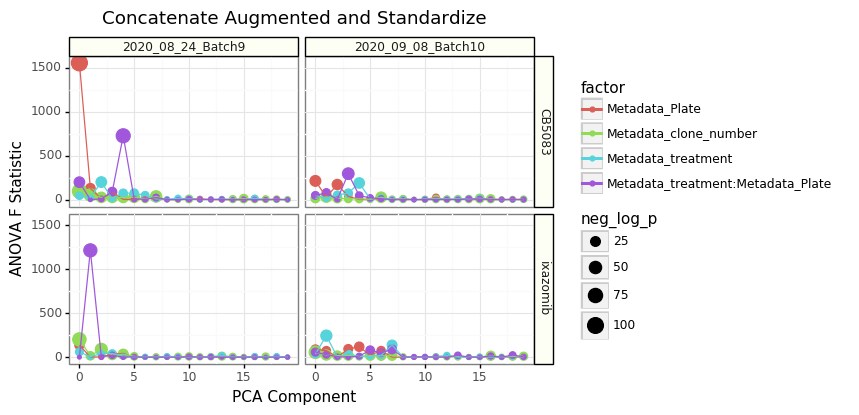

<ggplot: (311891944)>

In [9]:
naive_attempt_gg = (
    gg.ggplot(
        anova_results_full_new_normalized_df,
        gg.aes(x="component_number", y="F", color="factor")
    ) +
    gg.geom_point(gg.aes(size="neg_log_p")) +
    gg.geom_line() +
    gg.theme_bw() +
    gg.xlab("PCA Component") +
    gg.ylab("ANOVA F Statistic") +
    gg.facet_grid("compound~batch") +
    gg.theme(strip_background=gg.element_rect(colour="black", fill="#fdfff4")) +
    gg.ggtitle("Concatenate Augmented and Standardize")
)

output_file = pathlib.Path("figures_batch_effect/naive_correction_pca_anova_batch_effects.png")
naive_attempt_gg.save(output_file, height=4, width=6)

naive_attempt_gg